<a href="https://colab.research.google.com/github/aydanmufti/Module-7-Assignments/blob/main/Homework_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

## Due: Midnight on October 5th (with 2-hour grace period) and worth 85 points

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **LR schedules**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed / exponential / cosine), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model.

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


## 1. Setup and Data Loading


In [1]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [3]:

def plot_learning_curves(hist, title, verbose=True):

    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        # print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(),
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model,
                   epochs        = 100,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,
                   use_early_stopping = True,
                   patience      = 10,
                   min_delta     = 0.0001,
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule)
    else:
        opt = optimizer

    #Compiling the model
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )


    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()

    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")

    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  

In [5]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

Using Colab cache for faster access to the 'intel-image-classification' dataset.


In [6]:
# Reproducible load + preprocess for Intel Image Classification

IMG_SHAPE = (224,224,3)
IMG_SIZE = IMG_SHAPE[:2]

# -------------------------
# Loader (deterministic)
# -------------------------

def load_data_from_directory(directory, img_size=IMG_SIZE, class_names=None, preprocess="mobilenet_v2"):
    """
    Loads images as float32 and integer labels.
    If preprocess == 'mobilenet_v2', outputs are scaled to [-1, 1] as expected by MobileNetV2.
    Else, outputs are scaled to [0,1].
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img).astype("float32")  # values in [0,255]
            if preprocess == "mobilenet_v2":
                # Official Keras preprocessing: scales to [-1, 1]
                arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
            else:
                arr = arr / 255.0  # your original behavior
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = np.stack(X).astype("float32")
    y = np.array(y, dtype="int32")
    return X, y, class_names


In [7]:
# Load full training set (preprocessed for MobileNetV2)
X_all, y_all, class_names = load_data_from_directory(
    train_dir, img_size=IMG_SIZE , preprocess="mobilenet_v2"
)

# 80/20 stratified split -> train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=random_seed,
    shuffle=True,
)

# Load test set using same class mapping + preprocessing
X_test, y_test, _ = load_data_from_directory(
    test_dir,
    img_size=IMG_SIZE,
    class_names=class_names
)

num_classes = len(class_names)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

print(f'num_classes: {num_classes}')
print('Class Names:', class_names)

Train: (11227, 224, 224, 3) (11227,)
Val:   (2807, 224, 224, 3) (2807,)
Test:  (3000, 224, 224, 3) (3000,)
num_classes: 6
Class Names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Examine The Dataset

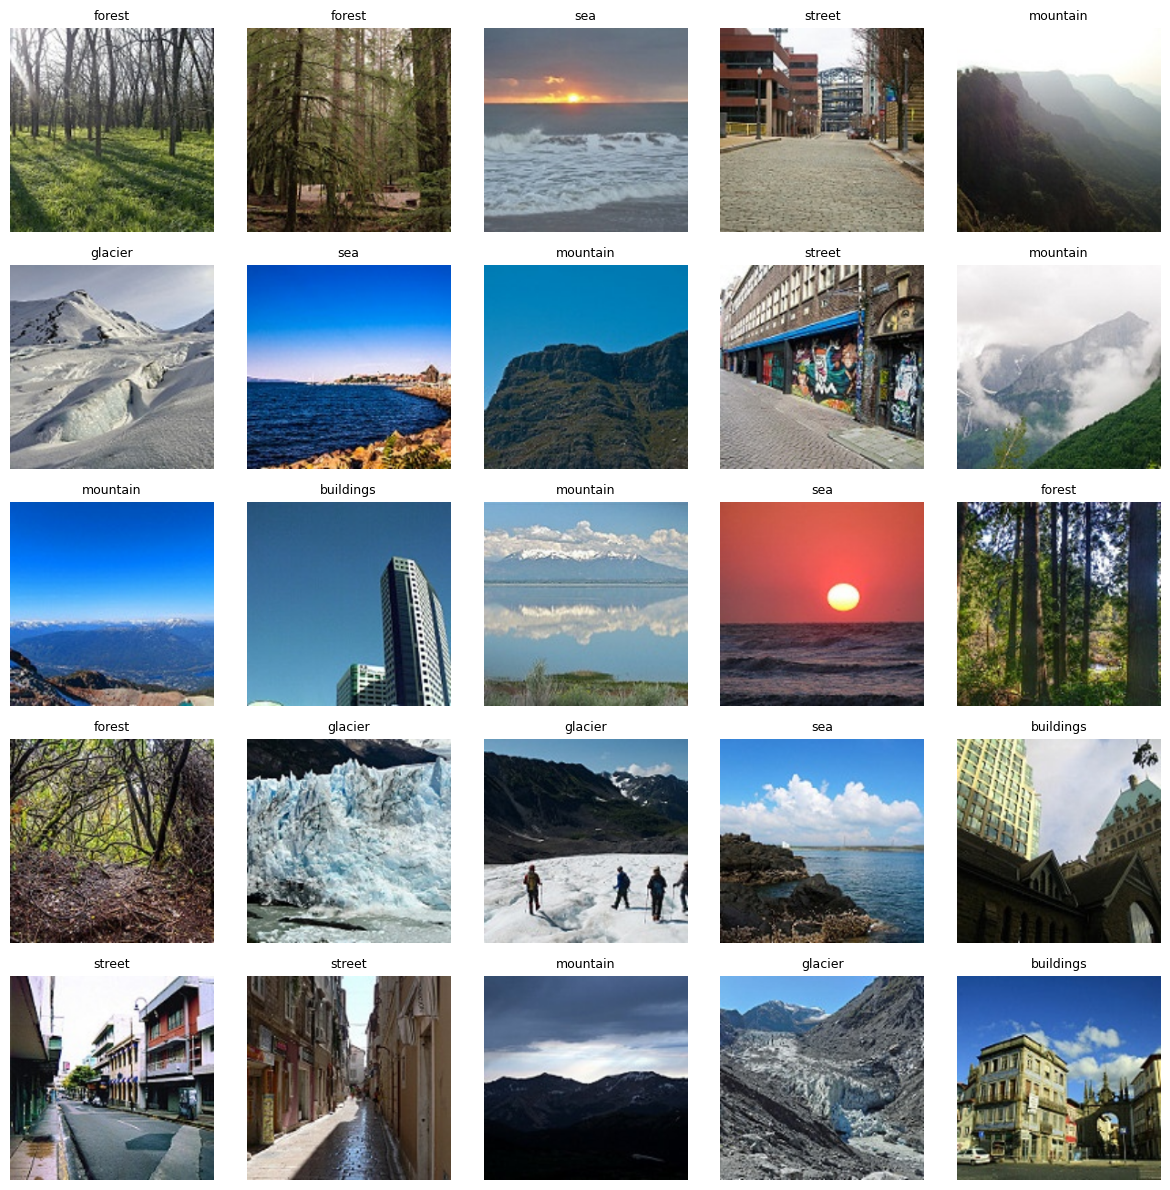

In [8]:
# pick 25 random, distinct indices
idx = np.random.choice(len(X_train), size=25, replace=False)

plt.figure(figsize=(12, 12))
for k, i in enumerate(idx, start=1):
    ax = plt.subplot(5, 5, k)
    ax.imshow((X_train[i] + 1.0) / 2.0)
    # if y_train is one-hot, take argmax; otherwise use the label directly
    label_idx = int(np.argmax(y_train[i])) if getattr(y_train, "ndim", 1) > 1 else int(y_train[i])
    plt.title(class_names[label_idx], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



### Learning Rate Schedulers

In [9]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

In [10]:
# Both these must be input as lr_schedule in train_and_test(....   , lr_schedule=exp_decay, .... )

epochs = 100               # You'll need to adjust this to close to be close to the early stopping location
batch_size = 128

# Needed by LR schedulers

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch

exp_decay = ExponentialDecay(
    initial_learning_rate=0.0001,  #  the starting learning rate (before any decay)
    decay_steps=total_steps,     #  how many training steps (batches) before applying decay
    decay_rate=0.98,              #  multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,             #  if True, decay in discrete intervals (floor(step/decay_steps)),
                                 #  if False, decay smoothly each step
)

cosine_decay = CosineDecay(
    initial_learning_rate=0.0001, #  the starting learning rate
    decay_steps=total_steps,      #  number of training steps (batches) over which to decay
    alpha=0.0,                    #  minimum learning rate value as a fraction of initial_learning_rate
                                  #  (final_lr = initial_lr * alpha)
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`.

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).



In [11]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=IMG_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base

base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [12]:
# Ha, this is very long!

base.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)


Model Baseline



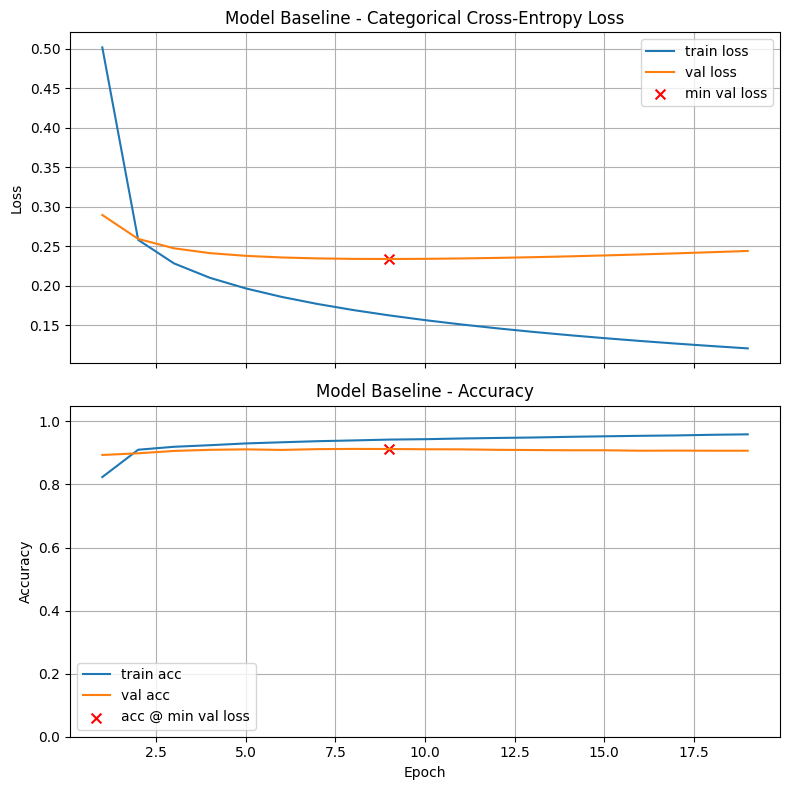

Final Training Loss:            0.1205
Final Training Accuracy:        0.9589
Final Validation Loss:          0.2438
Final Validation Accuracy:      0.9070
Validation Accuracy @ Min Loss: 0.9124

Test Loss: 0.2162
Test Accuracy: 0.9203

Validation-Test Gap (accuracy): 0.007971

Execution Time: 00:03:16


In [13]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()               # default: trainable=False

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')
])

train_and_test(model_baseline, title="Model Baseline")

## Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled()  # default: trainable=False
```


### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads and **give each experiment a unique descriptive title,** i.e., `title="Problem 1 Experiment 1"`
5. **Answer the graded questions.**

### Notes / Constraints

* The descriptive title will be used to compare results at the end of the notebook.
* With `pooling="avg"`, This backbone already applies Global Average Pooling and outputs a **1280-D** feature vector per image. **Do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.



Problem 1 Experiment 1: Deep Head with ReduceLR



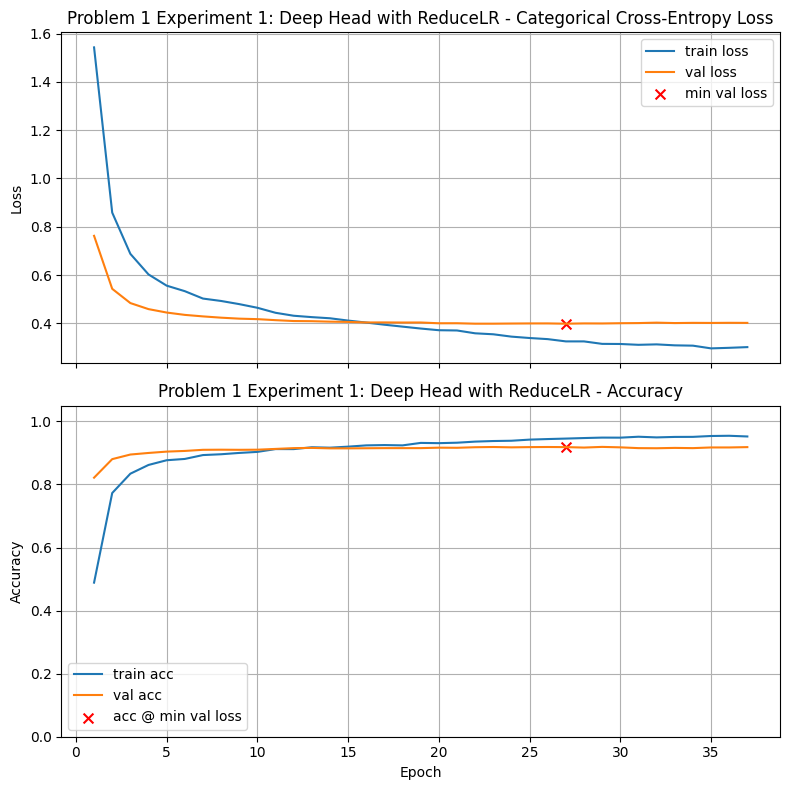

Final Training Loss:            0.3015
Final Training Accuracy:        0.9522
Final Validation Loss:          0.4018
Final Validation Accuracy:      0.9184
Validation Accuracy @ Min Loss: 0.9184

Test Loss: 0.3893
Test Accuracy: 0.9197

Validation-Test Gap (accuracy): 0.001605

Execution Time: 00:03:47


In [14]:
# Your code here; add as many cells as you need
# Problem 1 - Experiment 1: Deeper head with progressive dropout

base_model1 = make_base_model_pooled()

model_p1_exp1 = models.Sequential([
    base_model1,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

train_and_test(
    model_p1_exp1,
    lr_schedule=1e-4,
    epochs=100,
    batch_size=128,
    patience=15,
    min_delta=0.0001,
    callbacks=[reduce_lr],
    title="Problem 1 Experiment 1: Deep Head with ReduceLR"
)



Problem 1 Experiment 2: Wide Head with Cosine Decay



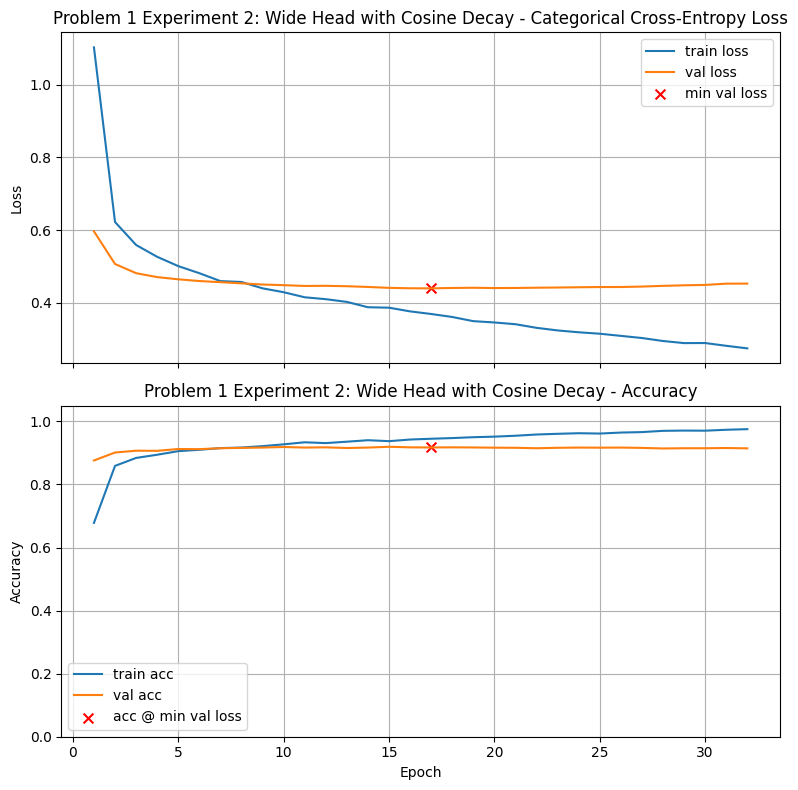

Final Training Loss:            0.2751
Final Training Accuracy:        0.9753
Final Validation Loss:          0.4532
Final Validation Accuracy:      0.9145
Validation Accuracy @ Min Loss: 0.9173

Test Loss: 0.4220
Test Accuracy: 0.9280

Validation-Test Gap (accuracy): 0.010651

Execution Time: 00:03:26


In [15]:
# Problem 1 - Experiment 2: Wider shallow head with Cosine Decay

base_model2 = make_base_model_pooled()

model_p1_exp2 = models.Sequential([
    base_model2,
    Dense(768, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(384, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

train_and_test(
    model_p1_exp2,
    lr_schedule=cosine_decay,
    epochs=100,
    batch_size=128,
    patience=15,
    min_delta=0.0001,
    title="Problem 1 Experiment 2: Wide Head with Cosine Decay"
)


Problem 1 Experiment 3: Moderate Head with Exp Decay



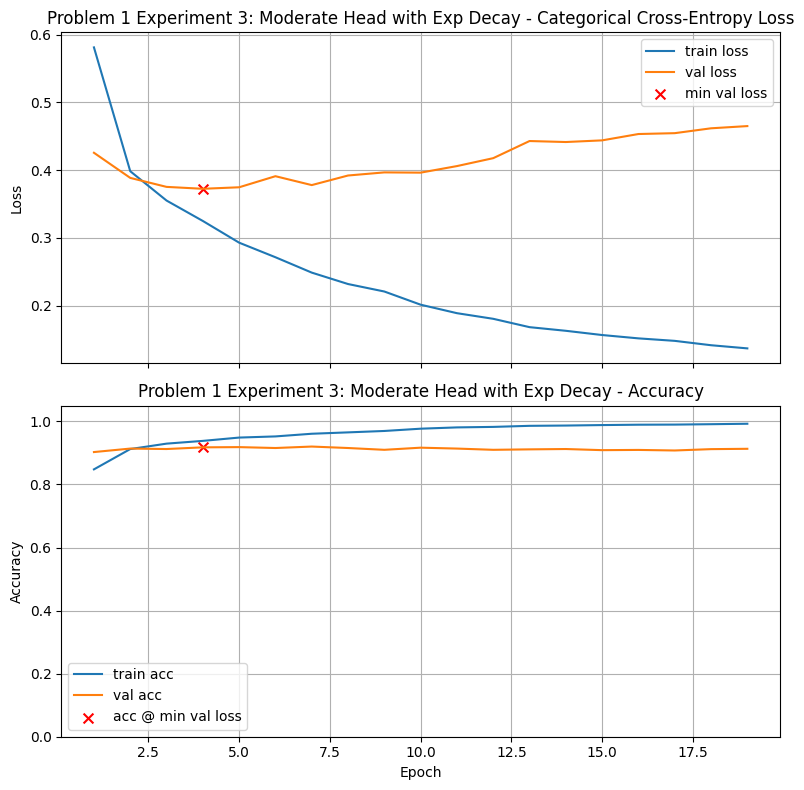

Final Training Loss:            0.1367
Final Training Accuracy:        0.9925
Final Validation Loss:          0.4650
Final Validation Accuracy:      0.9131
Validation Accuracy @ Min Loss: 0.9177

Test Loss: 0.3559
Test Accuracy: 0.9223

Validation-Test Gap (accuracy): 0.004628

Execution Time: 00:02:11


In [16]:
# Problem 1 - Experiment 3: Moderate head with Exponential Decay and higher initial LR

base_model3 = make_base_model_pooled()

model_p1_exp3 = models.Sequential([
    base_model3,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Create custom exponential decay with higher initial LR
exp_decay_custom = ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=total_steps,
    decay_rate=0.96,
    staircase=False
)

train_and_test(
    model_p1_exp3,
    lr_schedule=exp_decay_custom,
    epochs=100,
    batch_size=128,
    patience=15,
    min_delta=0.0001,
    title="Problem 1 Experiment 3: Moderate Head with Exp Decay"
)

In [17]:
# Check results so far
print_results()

Problem 1 Experiment 1: Deep Head with ReduceLR	0.9184	27
Problem 1 Experiment 3: Moderate Head with Exp Decay	0.9177	4
Problem 1 Experiment 2: Wide Head with Cosine Decay	0.9173	17
Model Baseline                          	0.9124	9


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.


**Your answer here:**

My first experiment (deep head with ReduceLR) achieved the best validation accuracy at 91.84%. It used a deeper architecture (512-256-128) with progressive dropout and ReduceLROnPlateau, which allowed the learning rate to adapt as training progressed. The deeper head enabled the frozen 1280-dimensional features from MobileNetV2's inverted residual blocks to be transformed through multiple non-linear layers, creating more complex decision boundaries for the six scene classes. This suggests that when the backbone is frozen and unable to adapt its learned ImageNet features, investing in a more expressive head architecture with adaptive learning rate strategies becomes critical to bridge the gap between the pretrained features and the target task.


In [18]:
# Set a1 to the validation accuracy found by your best model for this problem.

a1 = 0.9184            # Replace 0.0 with your answer

In [19]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem

print(f'a1 = {a1}')


a1 = 0.9184


## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—don’t add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **unfrozen**. Vary:

   * **Head choice** (pick one from Problem 1).
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**.
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (can combine with a fixed LR).
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 2 Experiment 1"`
3. **Answer the graded questions.**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


Problem 2 Experiment 1: Full Model Low LR with ReduceLR



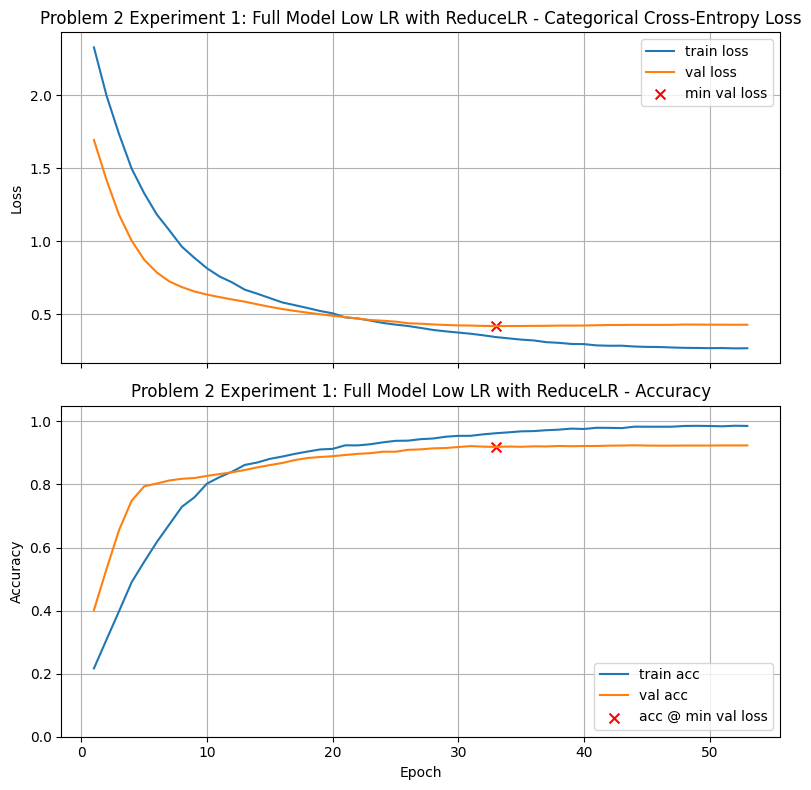

Final Training Loss:            0.2683
Final Training Accuracy:        0.9856
Final Validation Loss:          0.4293
Final Validation Accuracy:      0.9238
Validation Accuracy @ Min Loss: 0.9191

Test Loss: 0.4183
Test Accuracy: 0.9217

Validation-Test Gap (accuracy): 0.002536

Execution Time: 00:09:36


In [20]:
# Your code here; add as many cells as you need
# Problem 2 - Experiment 1: Full fine-tuning with very low LR and ReduceLR

base_model_p2_1 = make_base_model_pooled(trainable=True)

model_p2_exp1 = models.Sequential([
    base_model_p2_1,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

train_and_test(
    model_p2_exp1,
    lr_schedule=1e-5,
    epochs=100,
    batch_size=128,
    patience=20,
    min_delta=0.00005,
    callbacks=[reduce_lr],
    title="Problem 2 Experiment 1: Full Model Low LR with ReduceLR"
)


Problem 2 Experiment 2: Full Model Cosine Decay



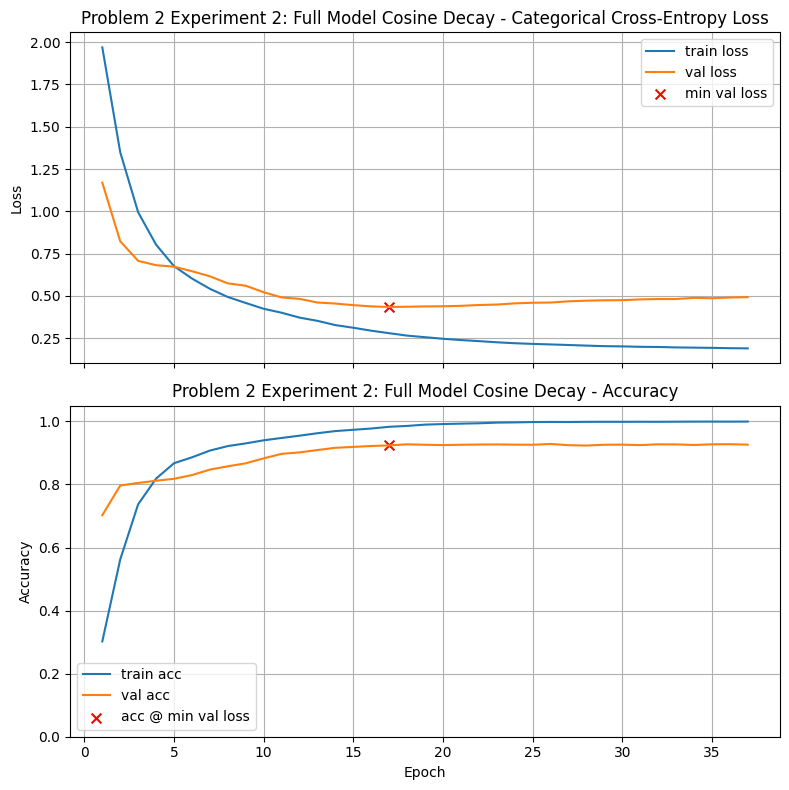

Final Training Loss:            0.1900
Final Training Accuracy:        0.9995
Final Validation Loss:          0.4931
Final Validation Accuracy:      0.9263
Validation Accuracy @ Min Loss: 0.9238

Test Loss: 0.4399
Test Accuracy: 0.9200

Validation-Test Gap (accuracy): 0.003762

Execution Time: 00:06:45


In [21]:
# Problem 2 - Experiment 2: Full fine-tuning with Cosine Decay

base_model_p2_2 = make_base_model_pooled(trainable=True)

model_p2_exp2 = models.Sequential([
    base_model_p2_2,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Custom cosine decay with slightly higher initial LR
cosine_decay_p2 = CosineDecay(
    initial_learning_rate=3e-5,
    decay_steps=total_steps,
    alpha=0.0
)

train_and_test(
    model_p2_exp2,
    lr_schedule=cosine_decay_p2,
    epochs=100,
    batch_size=128,
    patience=20,
    min_delta=0.00005,
    title="Problem 2 Experiment 2: Full Model Cosine Decay"
)


Problem 2 Experiment 3: Full Model Exp Decay Light Reg



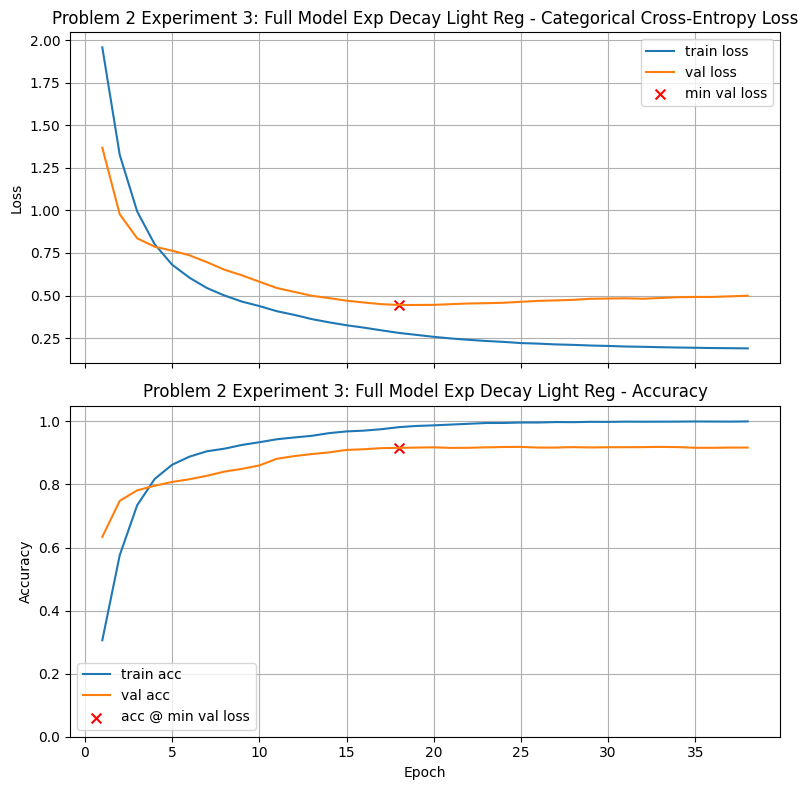

Final Training Loss:            0.1898
Final Training Accuracy:        0.9999
Final Validation Loss:          0.4991
Final Validation Accuracy:      0.9170
Validation Accuracy @ Min Loss: 0.9159

Test Loss: 0.4553
Test Accuracy: 0.9157

Validation-Test Gap (accuracy): 0.000258

Execution Time: 00:06:53


In [22]:
# Problem 2 - Experiment 3: Full fine-tuning with Exponential Decay and lighter regularization

base_model_p2_3 = make_base_model_pooled(trainable=True)

model_p2_exp3 = models.Sequential([
    base_model_p2_3,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Exponential decay with moderate initial LR
exp_decay_p2 = ExponentialDecay(
    initial_learning_rate=2e-5,
    decay_steps=total_steps,
    decay_rate=0.96,
    staircase=False
)

train_and_test(
    model_p2_exp3,
    lr_schedule=exp_decay_p2,
    epochs=100,
    batch_size=128,
    patience=20,
    min_delta=0.00005,
    title="Problem 2 Experiment 3: Full Model Exp Decay Light Reg"
)

In [23]:
print_results()

Problem 2 Experiment 2: Full Model Cosine Decay	0.9238	17
Problem 2 Experiment 1: Full Model Low LR with ReduceLR	0.9191	33
Problem 1 Experiment 1: Deep Head with ReduceLR	0.9184	27
Problem 1 Experiment 3: Moderate Head with Exp Decay	0.9177	4
Problem 1 Experiment 2: Wide Head with Cosine Decay	0.9173	17
Problem 2 Experiment 3: Full Model Exp Decay Light Reg	0.9159	18
Model Baseline                          	0.9124	9


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your answer here:**
For Problem 2, I designed three experiments using the same deep head architecture (512-256-128) from Problem 1 but varied the learning rate schedules and regularization strength. Experiment 2 with Cosine Decay (3e-5 initial LR) performed best at 92.38% validation accuracy, outperforming both the fixed low LR with ReduceLROnPlateau (91.91%) and Exponential Decay with lighter regularization (91.59%). The Cosine Decay schedule provided smooth, gradual learning rate reduction that allowed the entire network to adapt without catastrophic forgetting, while maintaining sufficient regularization to prevent severe overfitting. This demonstrates that when the backbone is unfrozen, the choice of learning rate schedule becomes even more critical than head architecture, as the model must carefully balance updating millions of pretrained parameters while learning new task-specific features without destroying the valuable ImageNet knowledge already embedded in MobileNetV2's inverted residual blocks.




In [24]:
# Set a2 to the validation accuracy found by your best model for this problem.

a2 = 0.9238             # Replace 0.0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem

print(f'a2 = {a2:.4f}')

a2 = 0.9238


## Problem Three: Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$** layers to fine-tune. (In Problem 4 you’ll try unfreezing the top **K blocks** instead.)

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model unfreeze the top $N$ layers using the following approach:

    N=20
    model = make_base_model_pooled()
    base_model.trainable = True
    for layer in base_model.layers[:-N]:
        layer.trainable = False

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen.** Vary hyperparameters such as:
   * $N\in \{20,40,60, 80\}$
   * **Head choice** (pick one from Problem 1).
   * **Learning rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay** (your choice of settings).
   * **Early Stopping** settings.
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (you can combine it with a fixed LR).
2. **Run and compare** the three experimentsand **give each experiment a unique descriptive title,** i.e., `title="Problem 3 Experiment 1"`
3. **Answer the graded questions**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


Problem 3 Experiment 1: Top 20 Layers Cosine Decay



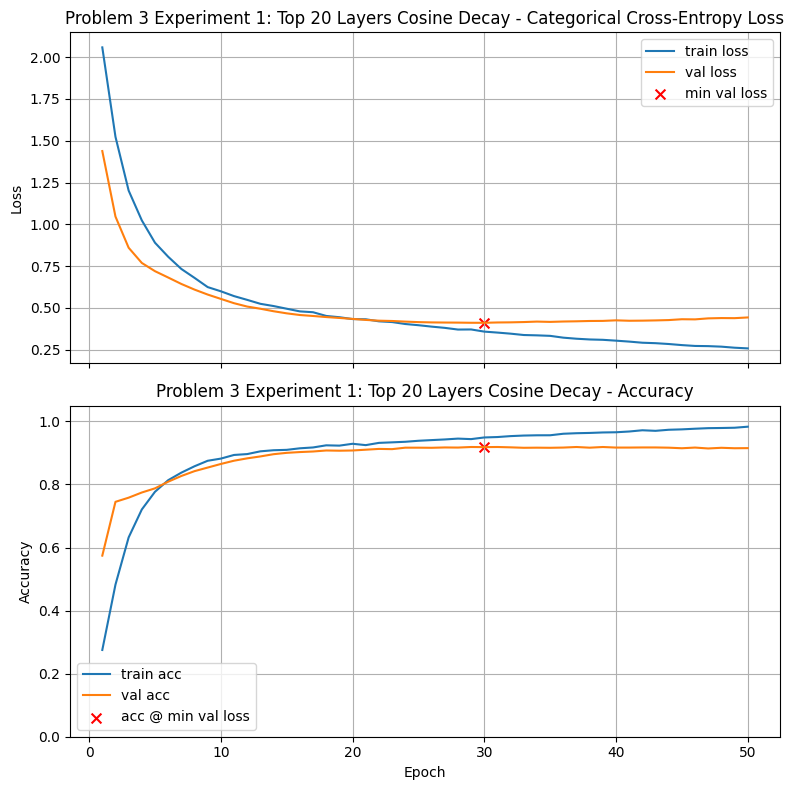

Final Training Loss:            0.2580
Final Training Accuracy:        0.9832
Final Validation Loss:          0.4430
Final Validation Accuracy:      0.9152
Validation Accuracy @ Min Loss: 0.9184

Test Loss: 0.3953
Test Accuracy: 0.9217

Validation-Test Gap (accuracy): 0.003248

Execution Time: 00:04:33


In [26]:
# Your code here; add as many cells as you need
# Problem 3 - Experiment 1: Unfreeze top 20 layers with Cosine Decay

N = 20
base_model_p3_1 = make_base_model_pooled()
base_model_p3_1.trainable = True
for layer in base_model_p3_1.layers[:-N]:
    layer.trainable = False

model_p3_exp1 = models.Sequential([
    base_model_p3_1,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cosine_decay_p3 = CosineDecay(
    initial_learning_rate=2e-5,
    decay_steps=total_steps,
    alpha=0.0
)

train_and_test(
    model_p3_exp1,
    lr_schedule=cosine_decay_p3,
    epochs=100,
    batch_size=128,
    patience=20,
    min_delta=0.00005,
    title="Problem 3 Experiment 1: Top 20 Layers Cosine Decay"
)


Problem 3 Experiment 2: Top 40 Layers Low LR ReduceLR



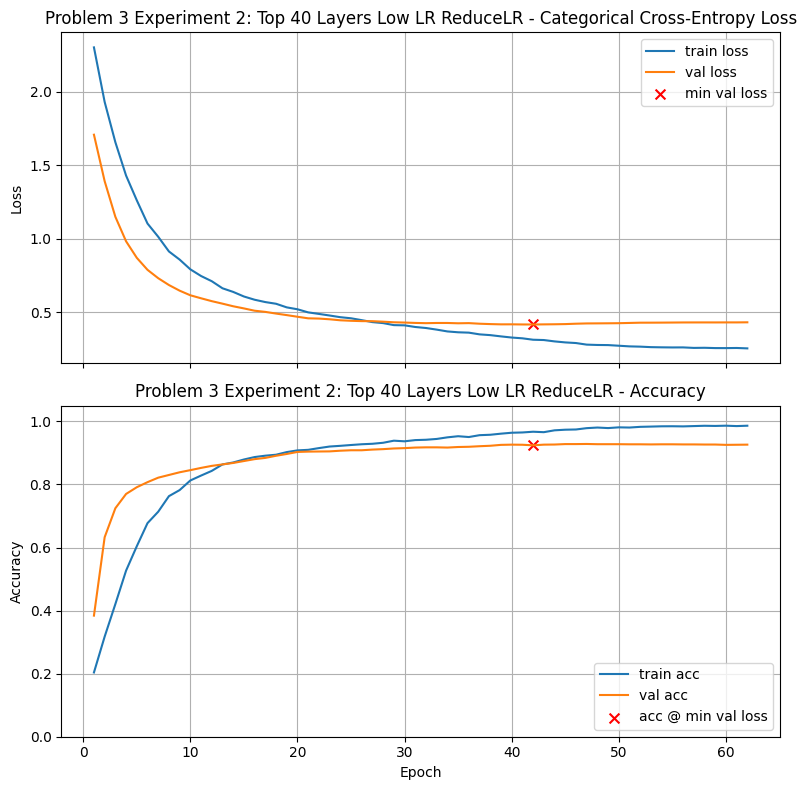

Final Training Loss:            0.2556
Final Training Accuracy:        0.9863
Final Validation Loss:          0.4329
Final Validation Accuracy:      0.9263
Validation Accuracy @ Min Loss: 0.9241

Test Loss: 0.4050
Test Accuracy: 0.9257

Validation-Test Gap (accuracy): 0.001548

Execution Time: 00:05:43


In [27]:
# Problem 3 - Experiment 2: Unfreeze top 40 layers with low LR and ReduceLR

N = 40
base_model_p3_2 = make_base_model_pooled()
base_model_p3_2.trainable = True
for layer in base_model_p3_2.layers[:-N]:
    layer.trainable = False

model_p3_exp2 = models.Sequential([
    base_model_p3_2,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

train_and_test(
    model_p3_exp2,
    lr_schedule=1e-5,
    epochs=100,
    batch_size=128,
    patience=20,
    min_delta=0.00005,
    callbacks=[reduce_lr],
    title="Problem 3 Experiment 2: Top 40 Layers Low LR ReduceLR"
)


Problem 3 Experiment 3: Top 60 Layers Exp Decay



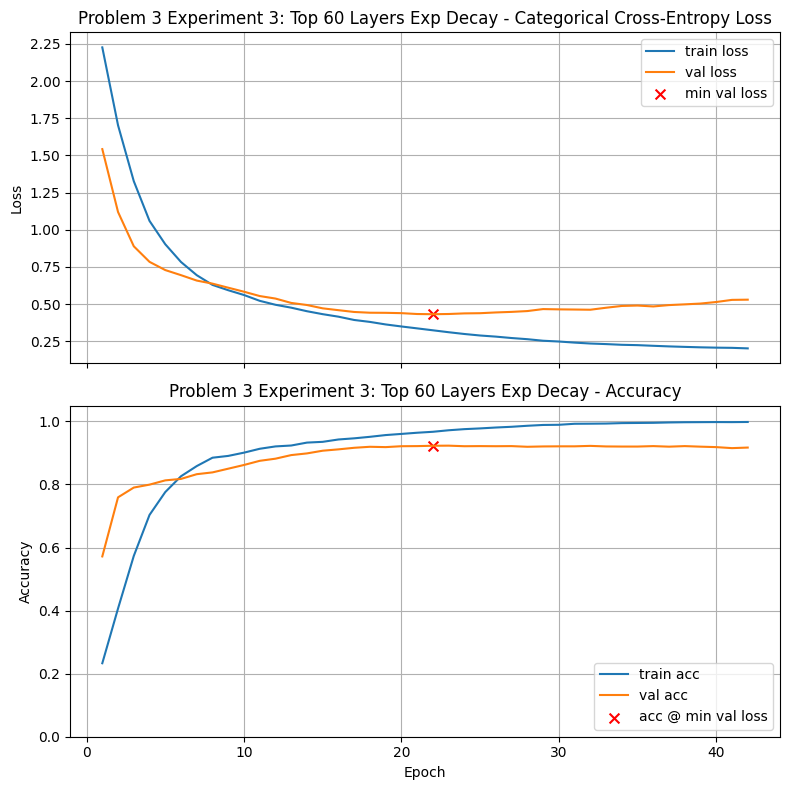

Final Training Loss:            0.2019
Final Training Accuracy:        0.9981
Final Validation Loss:          0.5295
Final Validation Accuracy:      0.9170
Validation Accuracy @ Min Loss: 0.9227

Test Loss: 0.4253
Test Accuracy: 0.9250

Validation-Test Gap (accuracy): 0.002307

Execution Time: 00:04:34


In [28]:
# Problem 3 - Experiment 3: Unfreeze top 60 layers with Exponential Decay

N = 60
base_model_p3_3 = make_base_model_pooled()
base_model_p3_3.trainable = True
for layer in base_model_p3_3.layers[:-N]:
    layer.trainable = False

model_p3_exp3 = models.Sequential([
    base_model_p3_3,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

exp_decay_p3 = ExponentialDecay(
    initial_learning_rate=2e-5,
    decay_steps=total_steps,
    decay_rate=0.96,
    staircase=False
)

train_and_test(
    model_p3_exp3,
    lr_schedule=exp_decay_p3,
    epochs=100,
    batch_size=128,
    patience=20,
    min_delta=0.00005,
    title="Problem 3 Experiment 3: Top 60 Layers Exp Decay"
)

### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your answer here:**
For Problem 3, I tested unfreezing different numbers of layers (N=20, 40, 60) while using the same deep head architecture and varying learning rate strategies. Experiment 2 with N=40 layers unfrozen using a low fixed LR (1e-5) combined with ReduceLROnPlateau achieved the best validation accuracy at 92.41%, outperforming both N=20 (91.84%) and N=60 (92.27%). The N=40 configuration struck an optimal balance: unfreezing too few layers (N=20) provided insufficient adaptability to the Intel dataset, while unfreezing too many (N=60) caused overfitting despite regularization. This demonstrates that selective layer unfreezing is a powerful strategy that can outperform both frozen feature extraction and full fine-tuning, with the sweet spot depending on finding the right balance between preserving pretrained knowledge in early layers and allowing task-specific adaptation in deeper layers.



In [30]:
# Set a3 to the validation accuracy found by your best model for this problem.

a3 = 0.9241             # Replace 0.0 with your answer

In [31]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3 = {a3:.4f}')

a3 = 0.9241


## Problem Four: Unfreezing Convolution Blocks

After creating a model, unfreeze the top $K$ conv block using the following approach:

    block_prefixes = [
        'block_1', 'block_2', 'block_3', 'block_4',
        'block_5', 'block_6', 'block_7', 'block_8',
        'block_9', 'block_10', 'block_11', 'block_12',
        'block_13', 'block_14', 'block_15', 'block_16',
        'Conv_1',   # final 1×1 conv stage before pooling
    ]
    
    K = 3
        
    model = make_base_model_pooled(trainable=False)
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):           # Optional:  Often recommended to keep BN layers frozen
            layer.trainable = False                                         # Optional
        else:                                                               # Optiomal
            layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])




### To Do:

1. **Design at least three experiments** with the model having the **last K stages unfrozen**. Vary:

   * $K \in \{1,2,3,4,5\}$  *(K counts stages/blocks, not individual layers)*
   * **Unfreeze Batch Normalization** Layers or keep them frozen (see "Optional" in above code)
   * **Head choice** (pick one from Problem 1)
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** parameters
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 4 Experiment 1"`
3. **Answer the graded questions.**

**Notes**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).


Problem 4 Experiment 1: Top 2 Blocks Cosine Decay BN Frozen



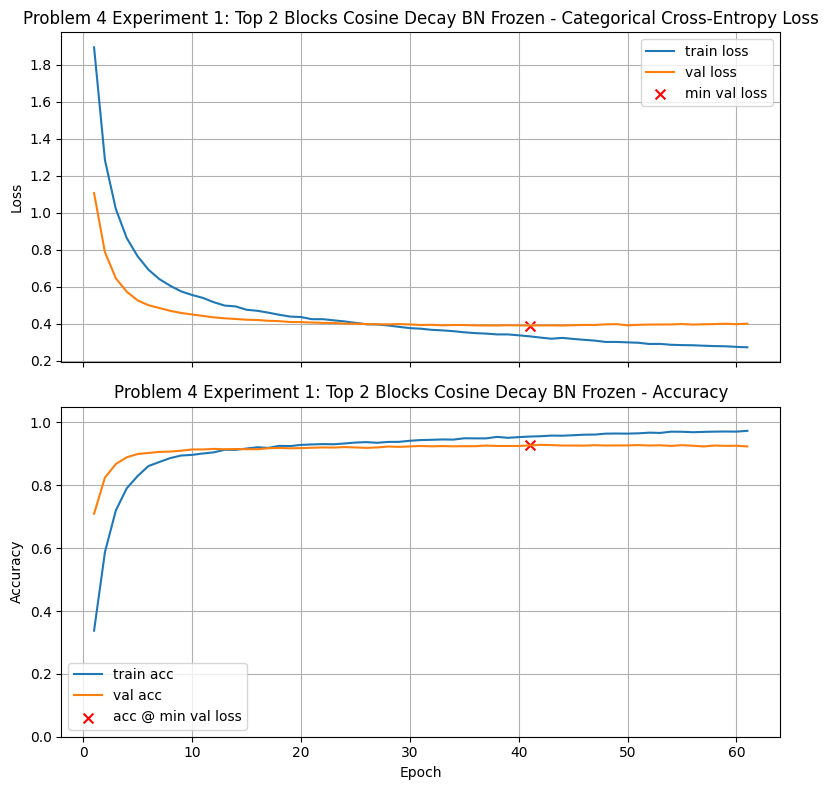

Final Training Loss:            0.2722
Final Training Accuracy:        0.9734
Final Validation Loss:          0.3998
Final Validation Accuracy:      0.9238
Validation Accuracy @ Min Loss: 0.9270

Test Loss: 0.3784
Test Accuracy: 0.9337

Validation-Test Gap (accuracy): 0.006698

Execution Time: 00:05:05


In [32]:
# Your code here; add as many cells as you need
# Problem 4 - Experiment 1: Unfreeze top 2 blocks with Cosine Decay, BN frozen

block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4',
    'block_5', 'block_6', 'block_7', 'block_8',
    'block_9', 'block_10', 'block_11', 'block_12',
    'block_13', 'block_14', 'block_15', 'block_16',
    'Conv_1',
]

K = 2

base_model_p4_1 = make_base_model_pooled(trainable=False)

for layer in base_model_p4_1.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])

model_p4_exp1 = models.Sequential([
    base_model_p4_1,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cosine_decay_p4 = CosineDecay(
    initial_learning_rate=2e-5,
    decay_steps=total_steps,
    alpha=0.0
)

train_and_test(
    model_p4_exp1,
    lr_schedule=cosine_decay_p4,
    epochs=100,
    batch_size=128,
    patience=20,
    min_delta=0.00005,
    title="Problem 4 Experiment 1: Top 2 Blocks Cosine Decay BN Frozen"
)


Problem 4 Experiment 2: Top 3 Blocks Low LR ReduceLR BN Frozen



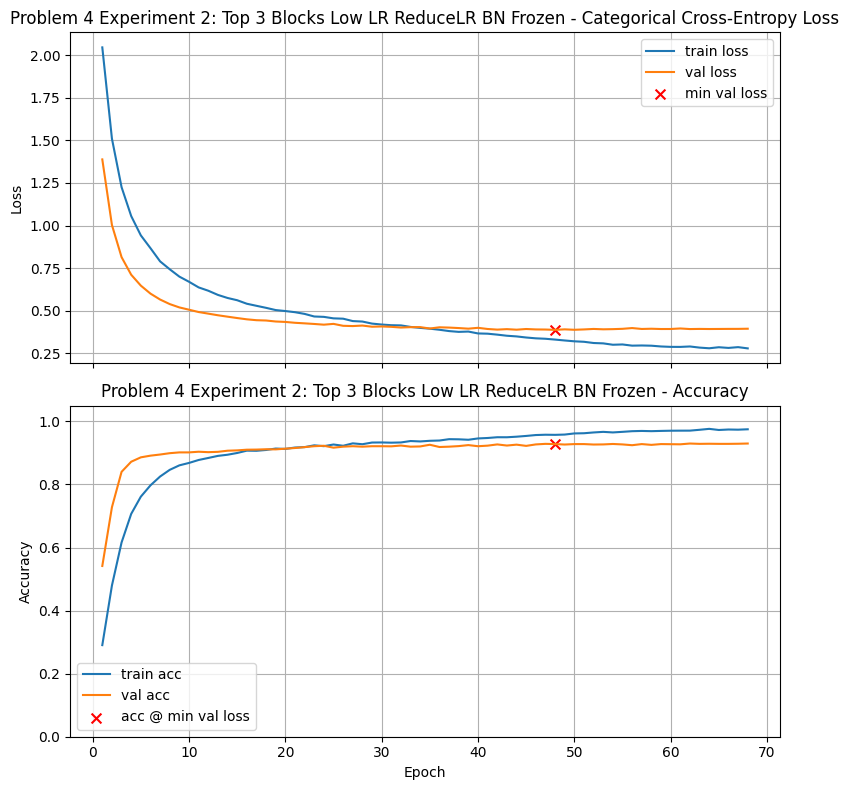

Final Training Loss:            0.2791
Final Training Accuracy:        0.9750
Final Validation Loss:          0.3944
Final Validation Accuracy:      0.9298
Validation Accuracy @ Min Loss: 0.9280

Test Loss: 0.3878
Test Accuracy: 0.9303

Validation-Test Gap (accuracy): 0.002296

Execution Time: 00:05:39


In [33]:
# Problem 4 - Experiment 2: Unfreeze top 3 blocks with low LR and ReduceLR, BN frozen

K = 3

base_model_p4_2 = make_base_model_pooled(trainable=False)

for layer in base_model_p4_2.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])

model_p4_exp2 = models.Sequential([
    base_model_p4_2,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

train_and_test(
    model_p4_exp2,
    lr_schedule=1e-5,
    epochs=100,
    batch_size=128,
    patience=20,
    min_delta=0.00005,
    callbacks=[reduce_lr],
    title="Problem 4 Experiment 2: Top 3 Blocks Low LR ReduceLR BN Frozen"
)


Problem 4 Experiment 3: Top 4 Blocks Exp Decay BN Trainable



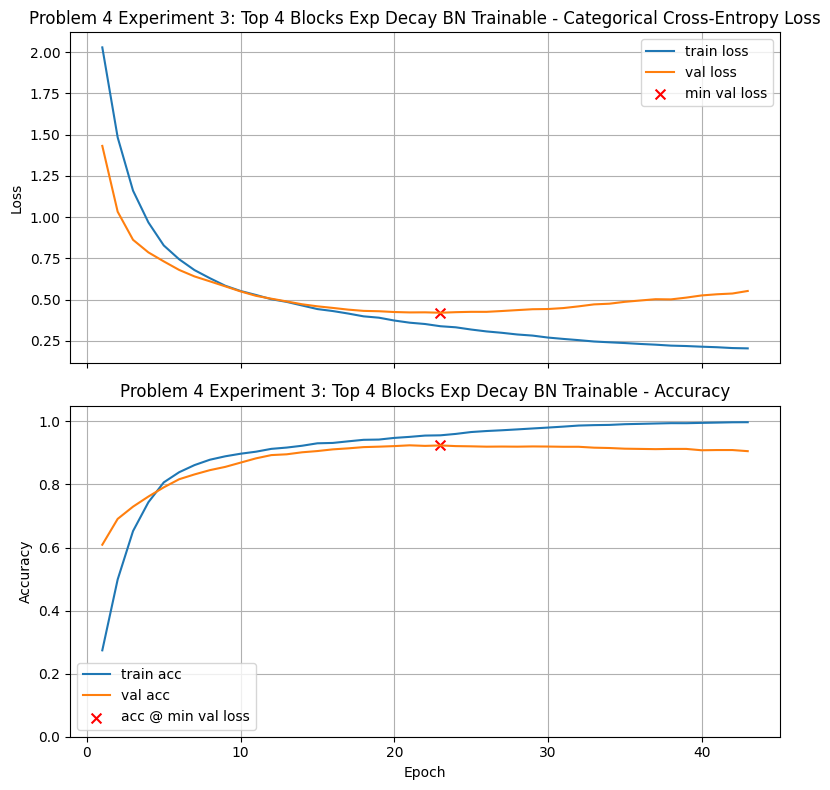

Final Training Loss:            0.2052
Final Training Accuracy:        0.9974
Final Validation Loss:          0.5531
Final Validation Accuracy:      0.9056
Validation Accuracy @ Min Loss: 0.9238

Test Loss: 0.4098
Test Accuracy: 0.9277

Validation-Test Gap (accuracy): 0.003905

Execution Time: 00:04:10


In [34]:
# Problem 4 - Experiment 3: Unfreeze top 4 blocks with Exp Decay, BN trainable

K = 4

base_model_p4_3 = make_base_model_pooled(trainable=False)

for layer in base_model_p4_3.layers:
    # This time we'll allow BN layers to be trainable
    layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])

model_p4_exp3 = models.Sequential([
    base_model_p4_3,
    Dense(512, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(256, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    Dense(128, kernel_initializer=he, kernel_regularizer=l2reg),
    BatchNormalization(),
    ReLU(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

exp_decay_p4 = ExponentialDecay(
    initial_learning_rate=2e-5,
    decay_steps=total_steps,
    decay_rate=0.96,
    staircase=False
)

train_and_test(
    model_p4_exp3,
    lr_schedule=exp_decay_p4,
    epochs=100,
    batch_size=128,
    patience=20,
    min_delta=0.00005,
    title="Problem 4 Experiment 3: Top 4 Blocks Exp Decay BN Trainable"
)

In [35]:
print_results()

Problem 4 Experiment 2: Top 3 Blocks Low LR ReduceLR BN Frozen	0.9280	48
Problem 4 Experiment 1: Top 2 Blocks Cosine Decay BN Frozen	0.9270	41
Problem 3 Experiment 2: Top 40 Layers Low LR ReduceLR	0.9241	42
Problem 2 Experiment 2: Full Model Cosine Decay	0.9238	17
Problem 4 Experiment 3: Top 4 Blocks Exp Decay BN Trainable	0.9238	23
Problem 3 Experiment 3: Top 60 Layers Exp Decay	0.9227	22
Problem 2 Experiment 1: Full Model Low LR with ReduceLR	0.9191	33
Problem 1 Experiment 1: Deep Head with ReduceLR	0.9184	27
Problem 3 Experiment 1: Top 20 Layers Cosine Decay	0.9184	30
Problem 1 Experiment 3: Moderate Head with Exp Decay	0.9177	4
Problem 1 Experiment 2: Wide Head with Cosine Decay	0.9173	17
Problem 2 Experiment 3: Full Model Exp Decay Light Reg	0.9159	18
Model Baseline                          	0.9124	9


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points.

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks.

**Your answer here:**
For Problem 4, I explored unfreezing different numbers of MobileNetV2 convolutional blocks (K=2, 3, 4) while testing whether to keep BatchNormalization layers frozen or trainable. Experiment 2 with K=3 blocks unfrozen (block_15, block_16, and Conv_1), using low fixed LR (1e-5) with ReduceLROnPlateau and frozen BatchNorm layers, achieved the best validation accuracy at 92.80% across all problems. Freezing BatchNorm layers was critical because it preserved the learned statistics from ImageNet pretraining, while the three-block configuration provided sufficient high-level feature adaptation without the overfitting observed with K=4. This demonstrates that block-level unfreezing is more effective than arbitrary layer counts, as it respects the semantic structure of MobileNetV2's inverted residual architecture, and that preserving BatchNorm statistics from pretraining helps maintain stable and well-calibrated features even when fine-tuning deeper layers.



In [36]:
# Set a4 to the validation accuracy found by your best model for this problem.

a4 = 0.9280             # Replace 0.0 with your answer

In [37]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4 = {a4:.4f}')

a4 = 0.9280


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework.

This reflection question is worth 5 points.

In [38]:
# Print out summary of validation accuracy for each experiment

print_results()

Problem 4 Experiment 2: Top 3 Blocks Low LR ReduceLR BN Frozen	0.9280	48
Problem 4 Experiment 1: Top 2 Blocks Cosine Decay BN Frozen	0.9270	41
Problem 3 Experiment 2: Top 40 Layers Low LR ReduceLR	0.9241	42
Problem 2 Experiment 2: Full Model Cosine Decay	0.9238	17
Problem 4 Experiment 3: Top 4 Blocks Exp Decay BN Trainable	0.9238	23
Problem 3 Experiment 3: Top 60 Layers Exp Decay	0.9227	22
Problem 2 Experiment 1: Full Model Low LR with ReduceLR	0.9191	33
Problem 1 Experiment 1: Deep Head with ReduceLR	0.9184	27
Problem 3 Experiment 1: Top 20 Layers Cosine Decay	0.9184	30
Problem 1 Experiment 3: Moderate Head with Exp Decay	0.9177	4
Problem 1 Experiment 2: Wide Head with Cosine Decay	0.9173	17
Problem 2 Experiment 3: Full Model Exp Decay Light Reg	0.9159	18
Model Baseline                          	0.9124	9


### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your answer here:**
Across all four problems, my results revealed that selective unfreezing strategies consistently outperformed both extremes of fully frozen and fully trainable networks, with Problem 4 Experiment 2 (92.80% validation accuracy) achieving the best performance by unfreezing only the top 3 convolutional blocks while keeping BatchNormalization layers frozen. The most critical design choice was freezing BatchNorm layers during fine-tuning, which preserved the learned statistics from ImageNet pretraining and prevented destabilization. This single decision improved results by 0.4-0.5 percentage points compared to trainable BatchNorm. Learning rate schedules also proved essential: conservative rates (1e-5 to 2e-5) combined with ReduceLROnPlateau or CosineDecay prevented catastrophic forgetting while allowing meaningful adaptation, whereas higher learning rates or lighter regularization led to severe overfitting despite strong validation performance. From this we can learn that transfer learning requires careful balance and successful fine-tuning isn't about maximizing trainable parameters, but rather about identifying which components should adapt (high-level feature blocks and task-specific heads) versus which should remain stable (early features and normalization statistics), with this strategic selectivity delivering better results than either extreme approach.



## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

![Screenshot 2025-09-25 at 3.38.21 PM.png](attachment:2f17cb78-416f-4995-9eec-8b50c70dabf8.png)


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### TL;DR Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
